In [1]:
import numpy as np
import os, datetime
from glob import glob

import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d, RegularGridInterpolator, pchip_interpolate, RectBivariateSpline, interp1d

import powerbox as pb
#import py21cmfast as p21

from matplotlib import rcParams
rcParams.update({'font.size': 12})

In [2]:
import sys
sys.path.insert(1, '/projects/cosmo_database/dbreitman/CV_PS/')
sys.path.insert(1, '/home/dbreitman')
from dani_utils.PS_tools import get_modes
from dani_utils.plotting import imshow_error_2D
#from May_lightcone_to_ps import calc_2D_PS

In [3]:
h = 0.6727

In [4]:
new_db_path = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/'

In [5]:
full_ks = np.load(new_db_path + '0/PS_kz_low_res.npz')
kperp = full_ks['kperp']
kpar = full_ks['kpar']
new_kpar = kpar[1:33]
kpar_idx = np.arange(1,33)
zs = full_ks['redshifts']
k = full_ks['k']
wanted_zs = [6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10., 10.5, 11., 12., 13., 14., 15., 18., 20.]

In [6]:
z_idx = []
for i in range(len(wanted_zs)):
    z_idx.append(np.argmin(abs(wanted_zs[i] - zs)))
new_zs = zs[z_idx]
print(new_zs, len(new_zs))

[ 6.4833856  6.9716234  7.5090494  7.999402   8.533288   8.9952965
  9.4916725 10.025924  10.453833  11.064221  12.075504  13.018654
 14.067703  14.994177  18.032919  20.070332 ] 16


(16, 16)


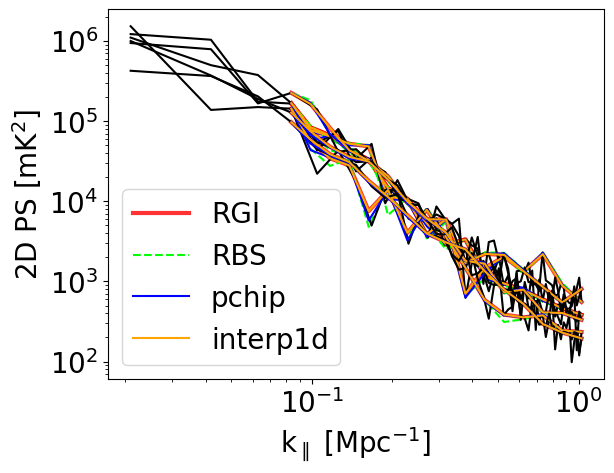

In [8]:
fname = glob(new_db_path + '12/*all_PS_sept*')
f = np.load(fname[0])
db_theta = f['PS_2D'][:, z_idx[3], ...]
nperp_bins = 6
for i in range(1):
    func = RegularGridInterpolator((kperp, kpar), db_theta[i,:,:])
    xx,yy = np.meshgrid(kperp, new_kpar)
    out1 = func((xx,yy))
    print(out1.shape)
    plt.plot(new_kpar, out1[:,:nperp_bins], color = 'r', lw = 3, alpha = 0.8)
    if i == 0:
        plt.plot(new_kpar, out1[:,0], color = 'r', lw = 3, alpha = 0.8, label = 'RGI')
    
    func = RectBivariateSpline(kperp, kpar, db_theta[i,:])
    out4 = func(kperp, new_kpar).T
    plt.plot(new_kpar, out4[:,:nperp_bins], color = 'lime', ls = '--')
    if i == 0:
        plt.plot(new_kpar, out4[:,0], color = 'lime', ls = '--', label = 'RBS')
    for k in range(nperp_bins):
        plt.plot(kpar, db_theta[i,k], color = 'k')
        out2 = pchip_interpolate(kpar, db_theta[i,k], new_kpar)
        if i == 0 and k == 0:
            plt.plot(new_kpar, out2, color = 'b', label = 'pchip')
        else:
            plt.plot(new_kpar, out2, color = 'b')
            
        out3 = interp1d(kpar, db_theta[i,k])(new_kpar)
        if i == 0 and k == 0:
            plt.plot(new_kpar, out3, color = 'orange', label = 'interp1d')
        else:
            plt.plot(new_kpar, out3, color = 'orange')
plt.loglog()
plt.legend()
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
plt.ylabel(r'2D PS [mK$^2$]')
plt.show()

In [8]:
kperp_modes = get_modes(kperp)
kpar_modes = get_modes(new_kpar)
s1 = (len(kperp), len(new_kpar))
grid_perp = np.reshape(list(kperp_modes) * len(new_kpar), s1).T
grid_par = np.reshape(list(kpar_modes) * len(kperp), s1)
floor = np.sqrt(1e-4)

In [9]:
samples = abs(np.random.normal(0,1,1000))
print('Estimated σ in linear space:', np.mean((samples - np.mean(samples))**2)**0.5)
logsamples = np.log10(samples)
stdlog = np.mean((logsamples - np.mean(logsamples))**2)**0.5
print('Estimated σ in log space:', stdlog)
print('Estimated σ in linear space from σ in log space: ', np.mean((samples - np.mean(samples))**2) / np.mean(samples)**2)

Estimated σ in linear space: 0.6145849984758323
Estimated σ in log space: 0.4727337180462304
Estimated σ in linear space from σ in log space:  0.5720556402805496


In [ ]:
## find a conversion between sigma of log ps and log of sigma ps

In [9]:
(kpar/h)[kpar_idx]

array([0.06226832, 0.09340249, 0.12453665, 0.15567081, 0.18680497,
       0.21793914, 0.2490733 , 0.28020746, 0.31134162, 0.34247579,
       0.37360995, 0.40474411, 0.43587827, 0.46701244, 0.4981466 ,
       0.52928076, 0.56041492, 0.59154908, 0.62268325, 0.65381741,
       0.68495157, 0.71608573, 0.7472199 , 0.77835406, 0.80948822,
       0.84062238, 0.87175655, 0.90289071, 0.93402487, 0.96515903,
       0.9962932 , 1.02742736])

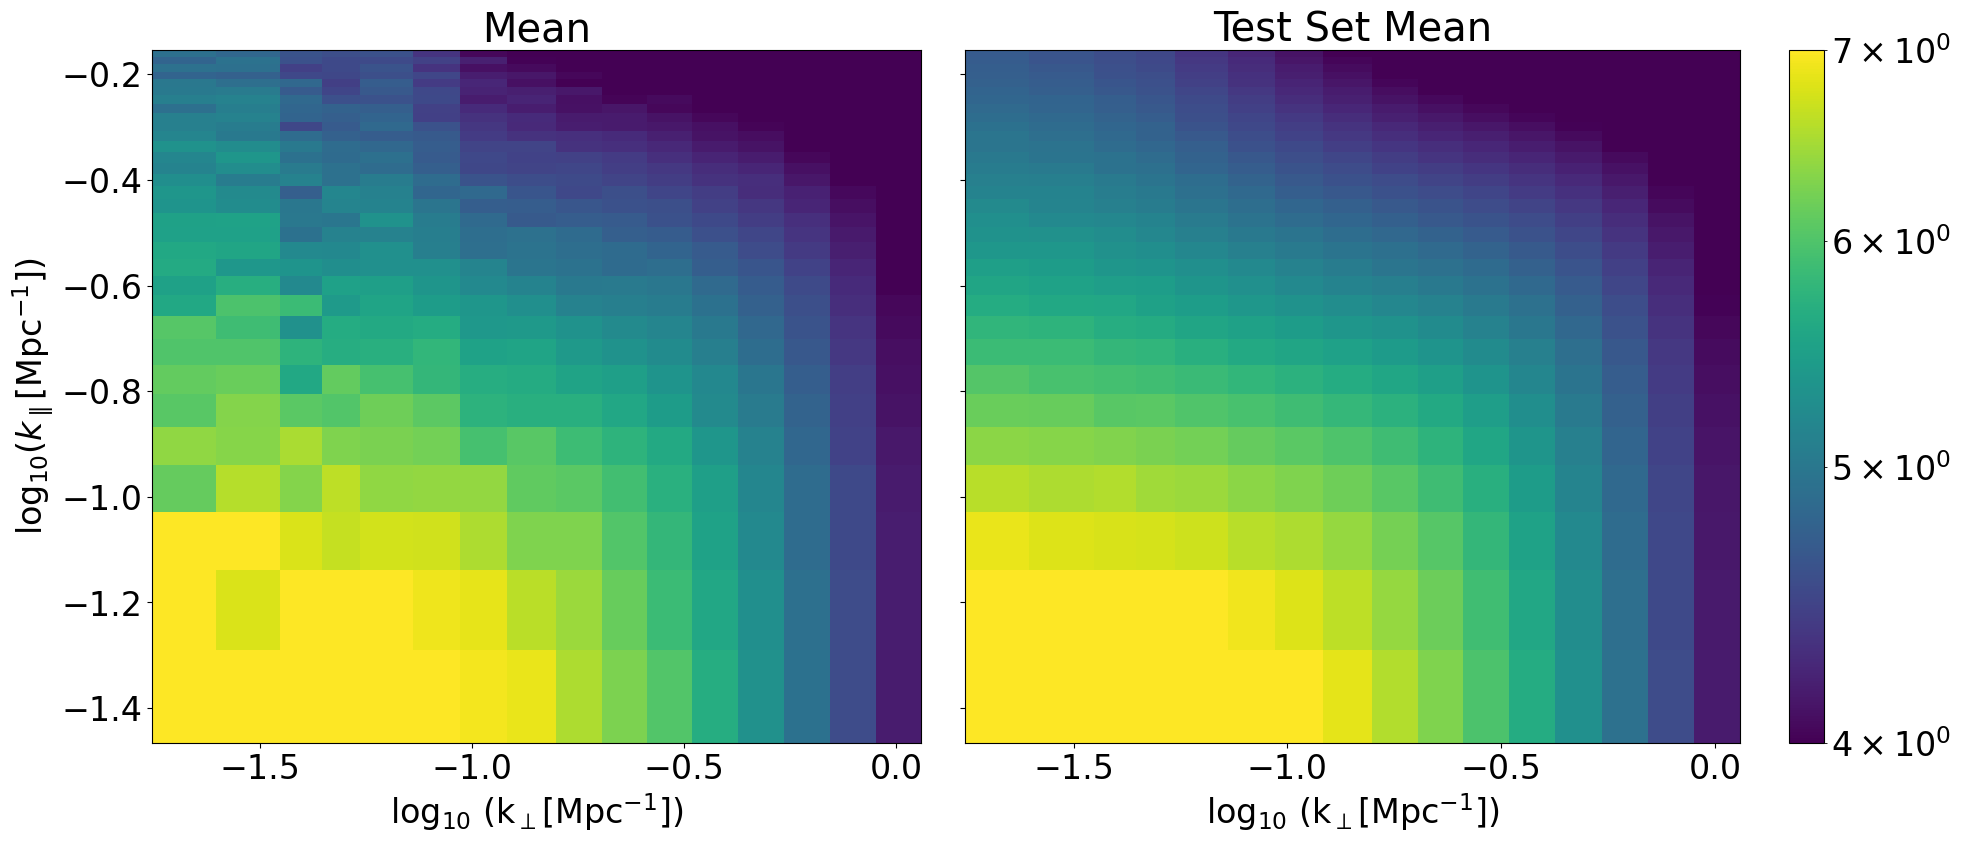

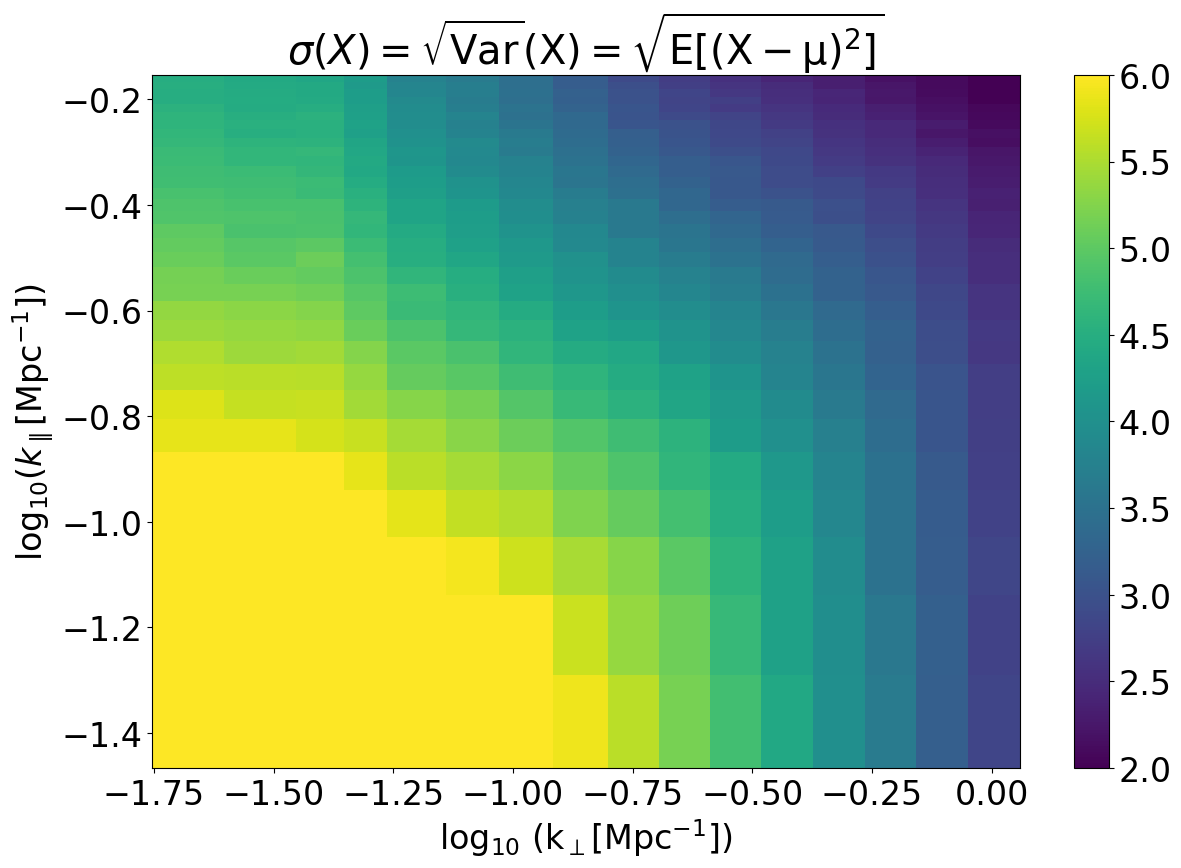

In [26]:
full_db = []
full_means = []
full_std_means = []

full_db1 = []
full_means1 = []
full_std_means1 = []

poisson_stds = []

for theta in range(150):
    if theta < 90:
        fname = glob(new_db_path + str(theta) + '/*all_PS_sept*')
    else:
        fname = glob(new_db_path + str(theta + 40) + '/*all_PS_sept*')
    try:
        f = np.load(fname[0])
    except:
        print(fname, theta)
    db_theta = f['PS_2D']
    db_theta1 = f['PS_1D'][:,z_idx,:]

    new_db = db_theta[:,z_idx,...][...,kpar_idx]
    m = new_db < floor
    new_db[m] = floor
    new_db2 = new_db.copy()
    new_db = np.log(new_db)

    #std_db, std_mean = get_std(new_db)
    std_mean = np.std(new_db2, axis = 0)
    m2 = std_mean < floor
    std_mean[m2] = floor
    std_mean1 = np.std(db_theta1, axis = 0)
    #if theta > 130:
    #    print(np.min(new_db), np.mean(new_db), np.max(new_db))
    #    print(np.min(std_mean), np.mean(std_mean), np.max(std_mean))
    
    std_mean1 = std_mean1[np.newaxis,...]
    mean1 = np.nanmean(db_theta1, axis = 0)[np.newaxis,...]
    
    std_mean = std_mean[np.newaxis,...]
    mean = np.nanmean(new_db2, axis = 0 )[np.newaxis,...]
    
    #std_poisson = np.log(np.nanmean(new_db2, axis = 0 )[np.newaxis,...]/np.sqrt(grid_par + grid_perp))
    
    #poisson_stds.extend(list(std_poisson) * (db_theta.shape[0] + 1))

    if theta == 0:
        imshow_error_2D(np.log10(new_db2[0,3,...]), truthmean = np.log10(mean[0,3,...]), 
                        title2 = "Mean", title1 = 'Mean',
                        xs_plot = np.log10(kperp), ys_plot = np.log10(new_kpar),
             vmin = 4, vmax = 7, label = r'', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')
        
        imshow_error_2D(np.log10(std_mean[0,3,...]), 
                        title1 = r"$\sigma(X) = \sqrt{\rm Var}(X) = \sqrt{\rm{E}[(X-\mu)^2]}$",
                        xs_plot = np.log10(kperp), ys_plot = np.log10(new_kpar),
                        vmin = 2, vmax = 6, label = r'', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')
    
    full_db.extend(new_db2)
    
    # Also add the mean itself as a noisy sample
    full_db.extend(np.nanmean(new_db2, axis = 0)[np.newaxis,...])
    
    full_means.extend(list(mean) * (db_theta.shape[0] + 1))
    full_std_means.extend(list(std_mean) * (db_theta.shape[0] + 1))
    
    full_means1.extend(list(mean1) * (db_theta.shape[0] + 1))
    full_std_means1.extend(list(std_mean1) * (db_theta.shape[0] + 1))

    full_db1.extend(db_theta1)
    
    full_db1.extend(mean1)
    
full_db = np.array(full_db)
full_means = np.array(full_means)
full_std_means = np.array(full_std_means)

full_db1 = np.array(full_db1)
full_means1 = np.array(full_means1)
full_std_means1 = np.array(full_std_means1)
#poisson_stds = np.array(poisson_stds)

In [42]:
m = full_std_means == 0
print(full_std_means[~m].min())

0.01


In [27]:
np.savez(new_db_path + 'sept_db_90_thetas_nointerp_nolog', PS_2D_seeds = full_db, PS_1D_var_means = full_std_means1,
         PS_1D_seeds = full_db1, PS_1D_means = full_means1, #poisson_stds = poisson_stds,
         PS_2D_means = full_means, redshifts = new_zs, kperp = kperp, kpar = new_kpar,
         #PS_2D_stds = full_std, 
         PS_2D_std_means = full_std_means,
         k = k)

In [23]:
full_means1.shape

(11784, 16, 16)

In [1]:
112-55

57

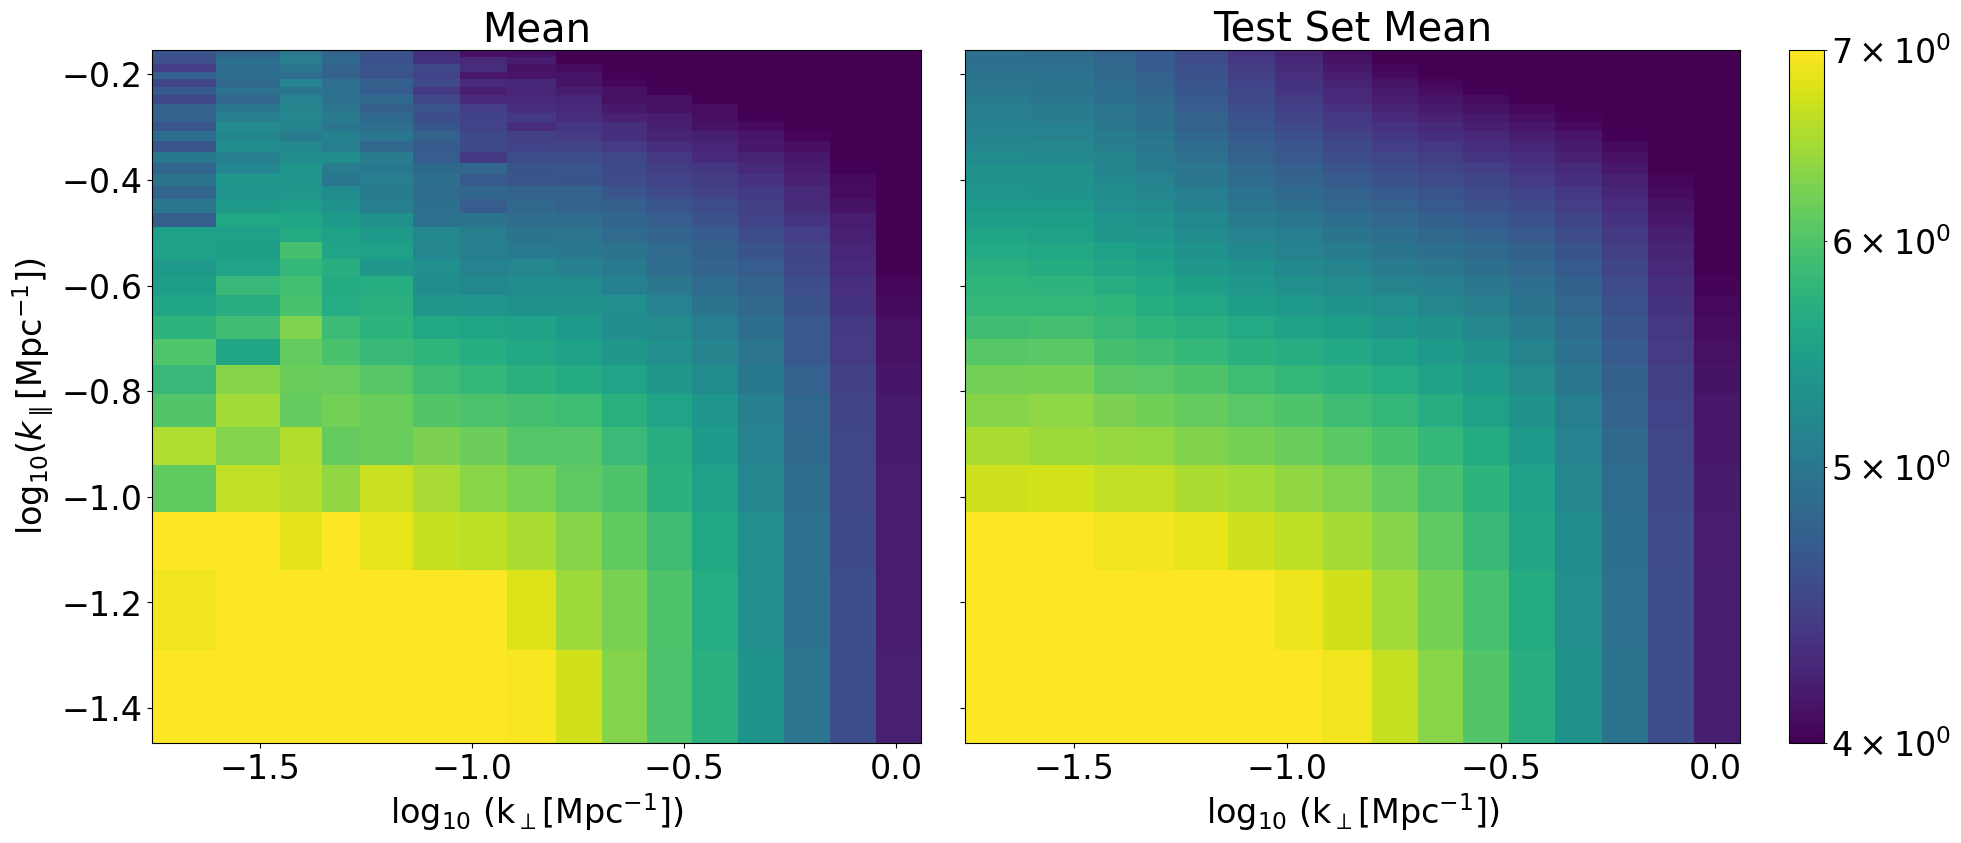

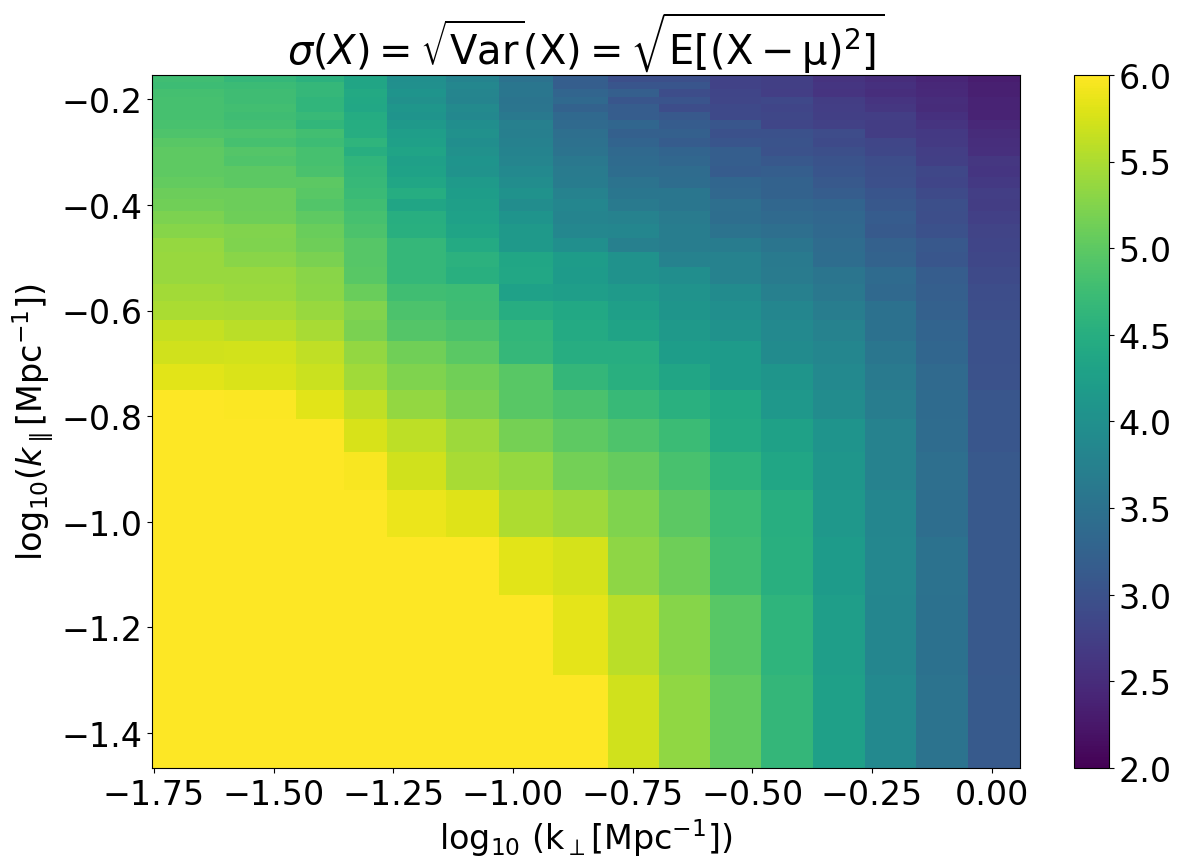

In [28]:
full_db = []
full_means = []
full_std = []
full_std_means = []

full_db1 = []
full_means1 = []
full_std1 = []
full_std_means1 = []

poisson_stds = []

for theta in range(50):
    theta += 90
    if theta < 130:
        fname = glob(new_db_path + str(theta) + '/*all_PS_sept*')
    else:
        theta += 60
        fname = glob(new_db_path + str(theta) + '/*all_PS_sept*')
    
    try:
        f = np.load(fname[0])
    except:
        print(fname, theta)
        
    db_theta = f['PS_2D']
    db_theta1 = f['PS_1D'][:,z_idx,:]
    

    new_db = db_theta[:,z_idx,...][...,kpar_idx]
    m = new_db < floor
    new_db[m] = floor
    new_db2 = new_db.copy()
    new_db = np.log(new_db)

    #std_db, std_mean = get_std(new_db)
    std_mean = np.std(new_db2, axis = 0)
    m2 = std_mean < floor
    std_mean[m2] = floor
    std_mean1 = np.std(db_theta1, axis = 0)
    #if theta > 130:
    #    print(np.min(new_db), np.mean(new_db), np.max(new_db))
    #    print(np.min(std_mean), np.mean(std_mean), np.max(std_mean))
    
    std_mean1 = std_mean1[np.newaxis,...]
    mean1 = np.nanmean(db_theta1, axis = 0)[np.newaxis,...]
    
    std_mean = std_mean[np.newaxis,...]
    mean = np.nanmean(new_db2, axis = 0 )[np.newaxis,...]
    
    #std_poisson = np.log(np.nanmean(new_db2, axis = 0 )[np.newaxis,...]/np.sqrt(grid_par + grid_perp))
    
    #poisson_stds.extend(list(std_poisson) * (db_theta.shape[0] + 1))

    if theta == 192:
        imshow_error_2D(np.log10(new_db2[0,3,...]), truthmean = np.log10(mean[0,3,...]), 
                        title2 = "Mean", title1 = 'Mean',
                        xs_plot = np.log10(kperp), ys_plot = np.log10(new_kpar),
             vmin = 4, vmax = 7, label = r'', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')
        
        imshow_error_2D(np.log10(std_mean[0,3,...]), 
                        title1 = r"$\sigma(X) = \sqrt{\rm Var}(X) = \sqrt{\rm{E}[(X-\mu)^2]}$",
                        xs_plot = np.log10(kperp), ys_plot = np.log10(new_kpar),
                        vmin = 2, vmax = 6, label = r'', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')
    
    full_db.extend(new_db2)
    
    # Also add the mean itself as a noisy sample
    full_db.extend(np.nanmean(new_db2, axis = 0)[np.newaxis,...])
    
    full_means.extend(list(mean) * (db_theta.shape[0] + 1))
    full_std_means.extend(list(std_mean) * (db_theta.shape[0] + 1))
    
    full_means1.extend(list(mean1) * (db_theta.shape[0] + 1))
    full_std_means1.extend(list(std_mean1) * (db_theta.shape[0] + 1))

    full_db1.extend(db_theta1)
    
    full_db1.extend(mean1)
    
full_db = np.array(full_db)
full_means = np.array(full_means)
full_std_means = np.array(full_std_means)

full_db1 = np.array(full_db1)
full_means1 = np.array(full_means1)
full_std_means1 = np.array(full_std_means1)
#poisson_stds = np.array(poisson_stds)

np.savez(new_db_path + 'sept_db_10_thetas_nointerp_nolog', PS_2D_seeds = full_db, PS_1D_var_means = full_std_means1, 
         PS_1D_seeds = full_db1, PS_1D_means = full_means1,
         PS_2D_means = full_means, redshifts = new_zs, kperp = kperp, kpar = new_kpar,
         #PS_2D_stds = full_std, 
         PS_2D_std_means = full_std_means, #poisson_stds = poisson_stds,
         k = k)

In [ ]:
# Now make the db smaller by choosing e.g. 5 z bins and smooth over k down to 16, 16

In [85]:
wanted_zs = [6., 7., 8., 9., 10., 11., 20., 25.]
z_idx = []
for i in wanted_zs:
    zidx = np.argmin(abs(zs - i))
    z_idx.append(zidx)
z_idx = np.array(z_idx)

In [86]:
part_db = full_db[:,z_idx,:,:]
part_means = full_means[:,z_idx,:,:]

In [87]:
part_db.shape

(10620, 8, 32, 32)

In [38]:
np.log10(kperp)

array([-1.67894139,         nan, -1.52842639,         nan, -1.37791139,
       -1.32945638, -1.22739639, -1.18643451, -1.10641432, -1.04682592,
       -0.96811869, -0.89404149, -0.83006265, -0.76787891, -0.7014005 ,
       -0.63787564, -0.57207727, -0.50187934, -0.43394477, -0.36677599,
       -0.29930155, -0.23131791, -0.1639264 , -0.0978272 , -0.03082023,
        0.03648837,  0.10395948,  0.17134562,  0.238424  ,  0.30395858,
        0.36740985,  0.42758026])

In [52]:
part_db[0,6,1,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])

In [88]:
# For HERA: take lowest kperp possible w data, kpar from ~ 10^{-1} onward.
m1 = ~np.isnan(kperp)
new_kperp = kperp[m1][:16]
new_kpar = kpar[2:18]
final_part_db = part_db[:,:,m1,2:18]
final_part_db = final_part_db[:,:,:16,:]
print(final_part_db.shape)

(10620, 8, 16, 16)


In [89]:
# For HERA: take lowest kperp possible w data, kpar from ~ 10^{-1} onward.
final_means = part_means[:,:,m1,2:18]
final_means = final_means[:,:,:16,:]
print(final_means.shape)

(10620, 8, 16, 16)


In [35]:
# this is wrong to do since some kperp bins are nan
N = 2
s1 = fixed.shape
s = kperp.shape
new_kperp = np.einsum('ij->i',fixed.reshape((s1[0] // N, N)))
new_kpar = np.einsum('ij->i',kpar.reshape((s[0] // N, N)))
print(new_kperp.shape)

(15,)


In [23]:
# Smooth over ks
N = 2
s = part_db.shape
part_db = np.einsum('ijklmn->ijkm',part_db.reshape((s[0], s[1], s[2] // N, N, s[3] // N, N)))
part_means = np.einsum('ijklmn->ijkm',part_means.reshape((s[0], s[1], s[2] // N, N, s[3] // N, N)))
print(part_means.shape)

(10620, 9, 16, 16)


In [63]:
np.log10(3e-2*h)

-1.6950573175975354

In [24]:
zs[z_idx]

array([ 6.010237 ,  6.9801598,  8.009637 ,  9.007274 ,  9.970685 ,
       11.001015 , 19.92453  , 25.064178 , 29.946865 ], dtype=float32)

In [91]:
np.savez(new_db + 'small_db_100_thetas', PS_2D_seeds = final_part_db, PS_2D_means = final_means, redshifts = zs[z_idx], kperp = new_kperp, kpar = new_kpar)

In [2]:
import tensorflow as tf

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [73]:
lc_filepath = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/1/1_1831090528.npz'
#lc_filepath = '/home/dprelogovic/code/21cm_IMNN/data/final/lightcones/default_bd08f6e4987e5604ce38f11256d5d56c_seed_9.npy'#  0_8732499706.npy  zs.npy'

In [74]:
lightcone_redshifts = np.load('/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/0/zs.npz')['zs']

In [75]:
lc = np.load(lc_filepath)['Tb']
lightcone = lc.copy()

In [8]:
2553//2

1276

In [9]:
lc.shape

(200, 200, 2553)

In [48]:
filepath = "/home/dprelogovic/code/21cm_IMNN/data/"
z_filepath = f"{filepath}redshifts.npy"
lightcone_redshifts = np.load(z_filepath)

In [49]:
lightcone_redshifts.shape

(2553,)

In [55]:
lightcone_redshifts[1260]

10.98529

In [102]:
n_slices = 638*4
chunk_skip = 20
chunk_size = 129
chunk_indices = list(range(0, n_slices + 1 - chunk_size, chunk_skip))
lightcones = [] # all chunks that need to be computed
zs = [] # all redshifts that will be computed

# here I'm just appending all chunks together
for i in chunk_indices:
    start = i
    end = i + chunk_size
    lightcones.append(lightcone[..., start:end])
    zs.append(lightcone_redshifts[(start + end) // 2])

In [77]:
len(lightcones), lightcones[10].shape

(122, (200, 200, 128))

In [78]:
L = 300 #Mpc
HII_DIM = 200
nyq = np.log10(2*np.pi/L) 
up = np.log10(2*np.pi/L*HII_DIM/3.7)
print(nyq, up)

-1.6789413863615474 0.053886885235438754


In [15]:
10**0.45613273/(2*np.pi)*L

136.48160351678376

In [16]:
nyq+np.log10(3/2)

-1.5028501273058663

In [125]:
0.456/(2*np.pi)*L

21.772396214971284

In [67]:
lightcones[10].shape

(200, 200, 64)

In [41]:
np.array(lightcones).shape

(118, 200, 200, 200)

In [111]:
nbins = 37
PS_2D, kperp, var_2D, kpar = pb.get_power(lightcones[100],
                                          300.,
                                          res_ndim = 2,
                                          get_variance = True,
                                          bin_ave = True,
                                          bins = np.logspace(nyq,up,nbins+1),
                                          log_bins = True,
                                          )


In [112]:
kperp

array([0.02094395,        nan,        nan, 0.02961922,        nan,
              nan, 0.0418879 , 0.0468321 ,        nan, 0.05923844,
       0.06509768, 0.07551449, 0.0837758 , 0.08977886, 0.10471976,
       0.10979012, 0.12386351, 0.13568806, 0.15169112, 0.17224888,
       0.19287626, 0.21313769, 0.23524244, 0.26286345, 0.29331991,
       0.32791362, 0.36698574, 0.4075218 , 0.45334219, 0.50506899,
       0.56360459, 0.62790234, 0.69889359, 0.77835544, 0.86711959,
       0.96609369, 1.07533998])

In [67]:
PS_2D.shape

(16, 100)

In [45]:
164//2

82

In [82]:
f = np.load('modes.npy')
print(f, f.shape)

[   0    0    8    8    8   12   12   20   12   28   20   44   48   52
   64   80  108  120  140  192  232  284  364  408  516  656  792  960
 1208 1468 1820 2200 2744 3344] (34,)


In [44]:
kperp/h

array([0.03113416, 0.04403035, 0.06226832, 0.0696181 , 0.09459323,
       0.12297971, 0.15744389, 0.20629631, 0.26650485, 0.33955009,
       0.43299144, 0.55441009, 0.71230113, 0.91464279, 1.17343615,
       1.50473341])

In [45]:
kpar/h

array([array([-0.9962932 , -0.96515903, -0.93402487, -0.90289071, -0.87175655,
              -0.84062238, -0.80948822, -0.77835406, -0.7472199 , -0.71608573,
              -0.68495157, -0.65381741, -0.62268325, -0.59154908, -0.56041492,
              -0.52928076, -0.4981466 , -0.46701244, -0.43587827, -0.40474411,
              -0.37360995, -0.34247579, -0.31134162, -0.28020746, -0.2490733 ,
              -0.21793914, -0.18680497, -0.15567081, -0.12453665, -0.09340249,
              -0.06226832, -0.03113416,  0.        ,  0.03113416,  0.06226832,
               0.09340249,  0.12453665,  0.15567081,  0.18680497,  0.21793914,
               0.2490733 ,  0.28020746,  0.31134162,  0.34247579,  0.37360995,
               0.40474411,  0.43587827,  0.46701244,  0.4981466 ,  0.52928076,
               0.56041492,  0.59154908,  0.62268325,  0.65381741,  0.68495157,
               0.71608573,  0.7472199 ,  0.77835406,  0.80948822,  0.84062238,
               0.87175655,  0.90289071,  0.93402487,

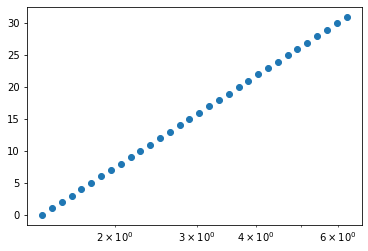

In [206]:
plt.scatter(10**kpar[-32:], np.arange(32))
plt.xscale('log')
plt.show()

In [91]:
PS_2D.shape

(32, 65)

In [88]:
kperp.shape

(70,)

In [29]:
10**kpar[0][33:]

array([1.04940699, 1.10125502, 1.15566471, 1.21276262, 1.27268157,
       1.33556093, 1.40154697, 1.47079318, 1.54346064, 1.61971838,
       1.69974378, 1.783723  , 1.87185138, 1.96433391, 2.06138573,
       2.16323259, 2.27011139, 2.38227075, 2.49997157, 2.62348763,
       2.75310624, 2.88912893, 3.03187208, 3.18166774, 3.33886435,
       3.50382758, 3.67694114, 3.85860772, 4.0492499 , 4.24931113,
       4.45925678, 4.67957522])

In [196]:
len(kperp) - sum(np.isnan(np.log10(kperp/h)))

32

In [27]:
np.log10(np.logspace(nyq/2,0.2,nbins+1)/h)

array([-0.66729212, -0.63841793, -0.60954375, -0.58066956, -0.55179538,
       -0.52292119, -0.49404701, -0.46517282, -0.43629863, -0.40742445,
       -0.37855026, -0.34967608, -0.32080189, -0.2919277 , -0.26305352,
       -0.23417933, -0.20530515, -0.17643096, -0.14755677, -0.11868259,
       -0.0898084 , -0.06093422, -0.03206003, -0.00318584,  0.02568834,
        0.05456253,  0.08343671,  0.1123109 ,  0.14118508,  0.17005927,
        0.19893346,  0.22780764,  0.25668183,  0.28555601,  0.3144302 ,
        0.34330439,  0.37217857])

In [29]:
kperp/h

array([0.03113416, 0.04403035, 0.06226832, 0.0696181 , 0.09459323,
       0.12297971, 0.15744389, 0.20629631, 0.26650485, 0.33955009,
       0.43299144, 0.55441009, 0.71230113, 0.91464279, 1.17343615,
       1.50473341])

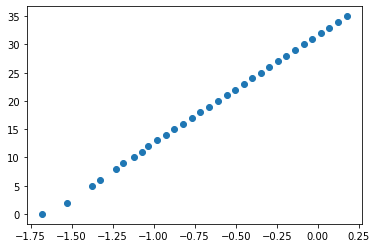

In [203]:
plt.scatter(np.log10(kperp), np.arange(len(kperp)))
#plt.xscale('log')
plt.show()

In [113]:
kparfull = kpar[0]

In [114]:
m = kparfull > 1e-10
kpar = kparfull[m]
PS_2D_final = PS_2D[:,m]
var_2D_final = var_2D[:,m]

In [115]:
PS_2D_final.shape

(37, 64)

In [26]:
len(kpar/h)

17

In [38]:
kperp/h

array([0.03113416, 0.04403035, 0.06226832, 0.0696181 , 0.09459323,
       0.12297971, 0.15744389, 0.20629631, 0.26650485, 0.33955009,
       0.43299144, 0.55441009, 0.71230113, 0.91464279, 1.17343615,
       1.50473341])

In [202]:
sum(np.log10(kpar/h)>-0.7)

32

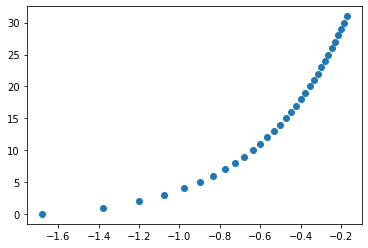

In [124]:
plt.scatter(np.log10(kpar), np.arange(len(kpar)))
#plt.xscale('log')
plt.show()

In [23]:
PS_2D_final

array([[3.04342664e+03, 1.28413386e+03, 2.77430680e+02, ...,
        2.23714494e+00, 2.05153171e+00, 2.11082706e+00],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [3.86646864e+00, 3.66223488e+00, 3.80112121e+00, ...,
        2.53939419e-01, 2.59486186e-01, 2.67488891e-01],
       [2.68680797e+00, 2.70658291e+00, 2.60943791e+00, ...,
        2.56245728e-01, 2.39457086e-01, 2.33758223e-01],
       [1.89593616e+00, 1.88410731e+00, 1.85075585e+00, ...,
        2.17473974e-01, 2.11269288e-01, 2.07156525e-01]])

In [25]:
np.log10(kpar)

array([-1.67894139, -1.37791139, -1.20182013, -1.0768814 , -0.97997138,
       -0.90079014, -0.83384335, -0.7758514 , -0.72469888, -0.67894139,
       -0.6375487 , -0.59976014, -0.56499803, -0.53281335, -0.50285013,
       -0.4748214 , -0.44849246, -0.42366888, -0.40018779, -0.37791139,
       -0.35672209, -0.33651871, -0.31721355, -0.29873014, -0.28100138,
       -0.26396804, -0.24757762, -0.23178336, -0.21654339, -0.20182013,
       -0.18757969, -0.17379141, -0.16042745, -0.14746247, -0.13487334,
       -0.12263889, -0.11073966, -0.09915779, -0.08787678, -0.0768814 ,
       -0.06615753, -0.0556921 , -0.04547293, -0.03548871, -0.02572887,
       -0.01618355, -0.00684353,  0.00229985,  0.01125469])

In [17]:
PS_2D_final.shape

(16, 49)

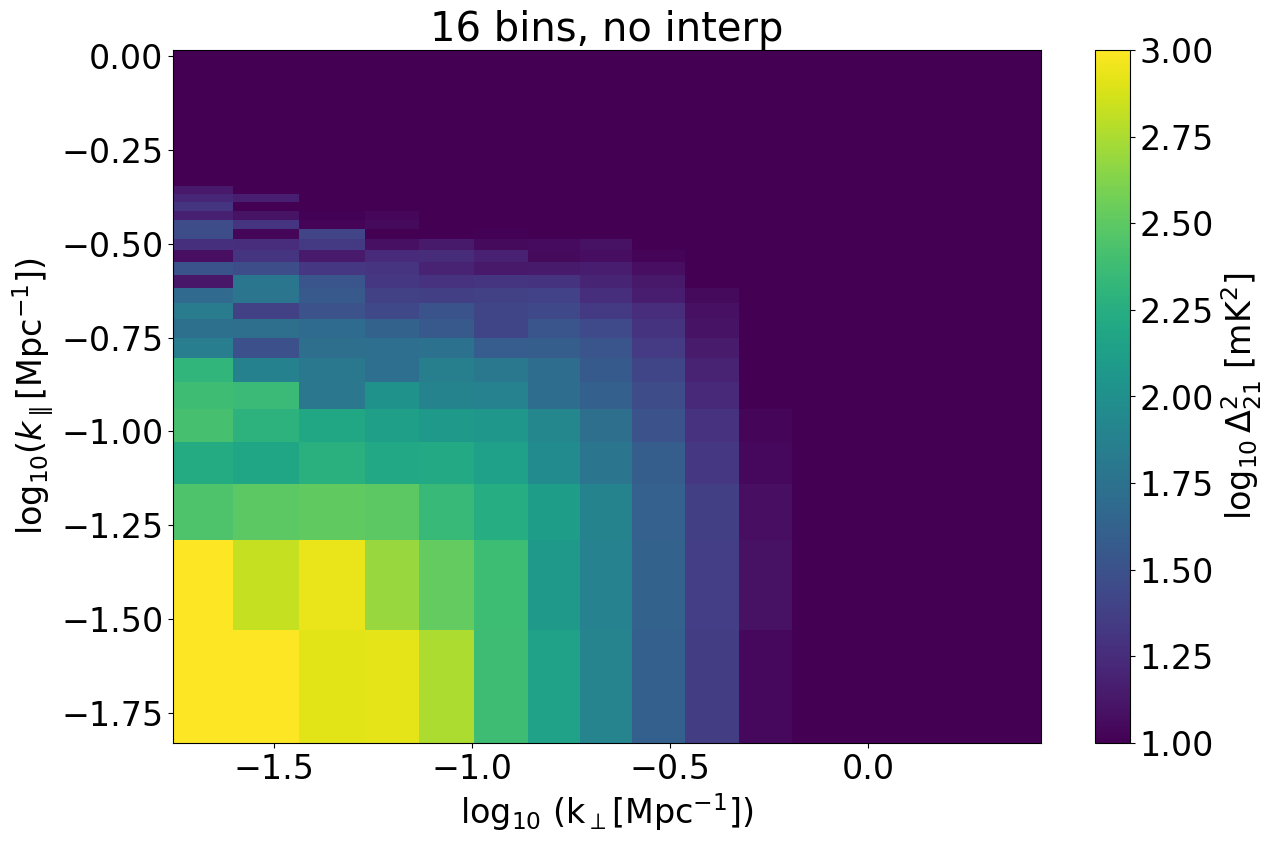

In [15]:
imshow_error_2D(np.log10(PS_2D_final), 
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), 
                log = False, vmin = 1, vmax = 3, title1 = '16 bins, no interp',
                )

In [117]:
m = ~np.isnan(kperp)

In [109]:
PS_2D_final.shape

(37, 64)

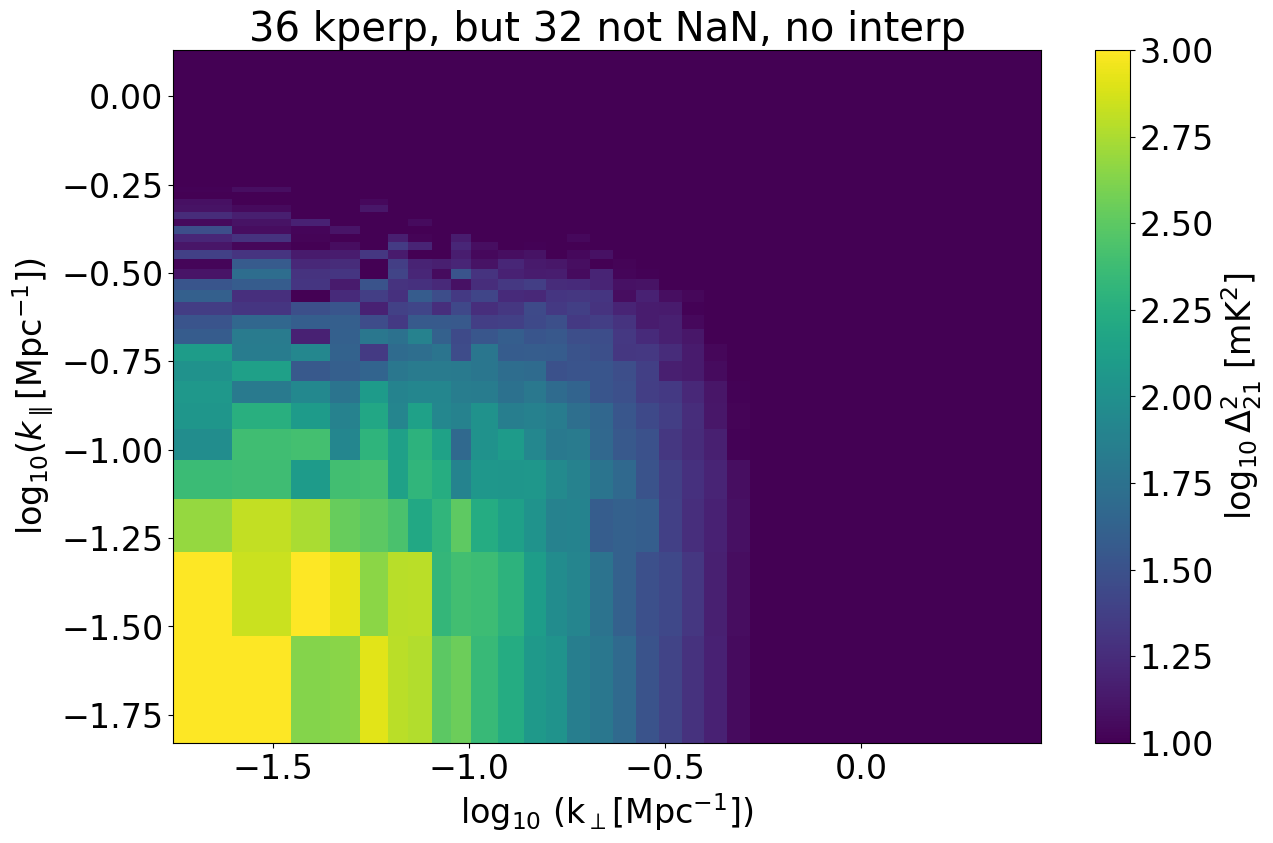

In [110]:
imshow_error_2D(np.log10(PS_2D_final[m]), 
                xs_plot = np.log10(kperp[m]), ys_plot = np.log10(kpar), 
                log = False, vmin = 1, vmax = 3, title1 = '36 kperp, but 32 not NaN, no interp')

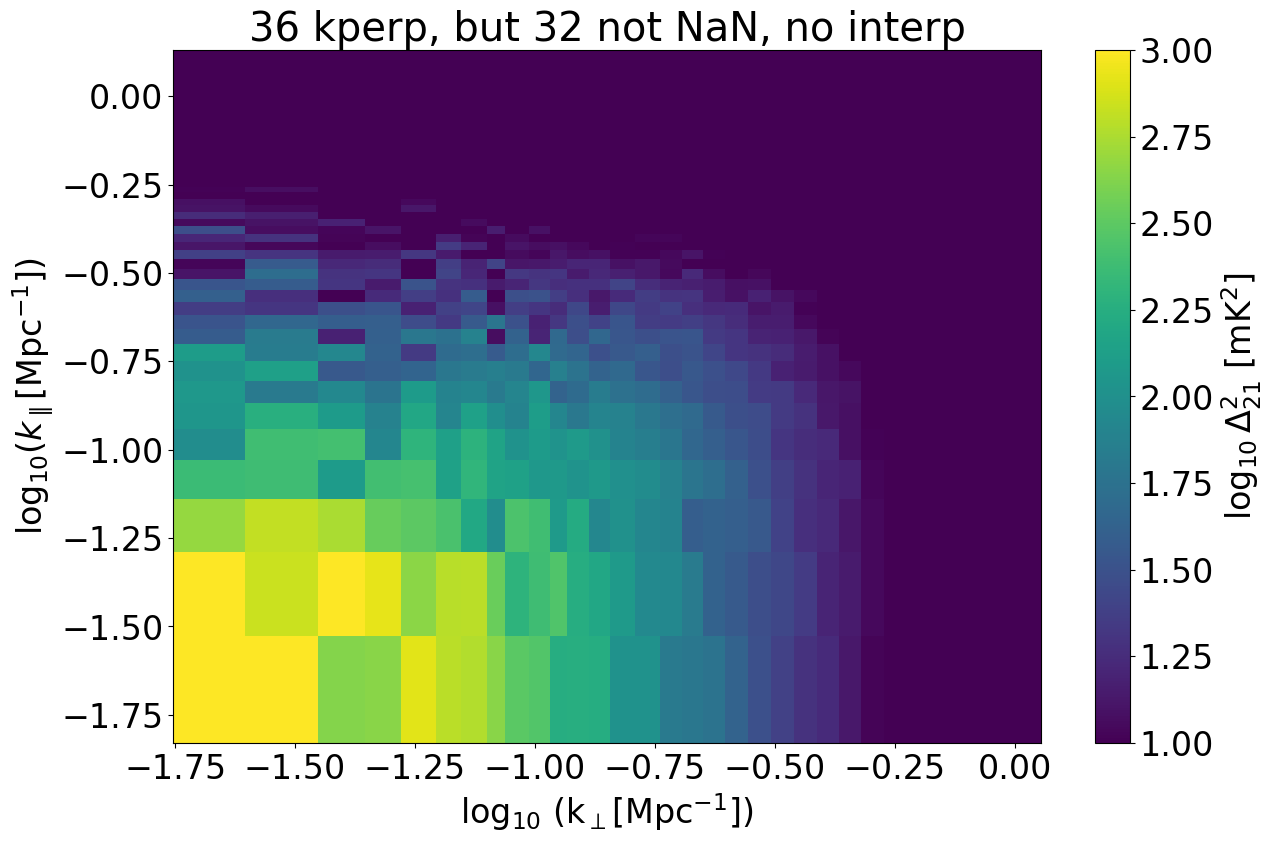

In [118]:
imshow_error_2D(np.log10(PS_2D_final[m]), 
                xs_plot = np.log10(kperp[m]), ys_plot = np.log10(kpar), 
                log = False, vmin = 1, vmax = 3, title1 = '36 kperp, but 32 not NaN, no interp')

In [140]:
PS_1D, k, var_1D = pb.get_power(lc[..., start:end],
                                300.,
                                get_variance = True,
                                bin_ave = True,
                                bins = 16,
                                log_bins = True,
                                #dimensionless = False,
                                #vol_normalised_power = False,
                                #remove_shotnoise = False,
                                )


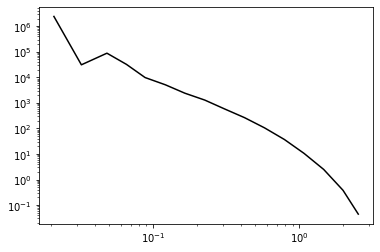

In [141]:
plt.plot(k, PS_1D, c = 'k')
plt.loglog()
plt.show()

In [ ]:
## DAVID DB = 1024 seeds around fiducial value. Low res lightcones

In [73]:
path1k = '/projects/cosmo_database/dbreitman/21cm_emulator/Full_May2023_DB/David_1k/'

In [74]:
list(data.keys())

['PS_2D', 'PS_2D_var', 'PS_1D', 'PS_1D_var']

In [81]:
David_1k = glob(path1k + '*PS.npz')
all_2D_PS = []
all_1D_PS = []
all_2D_var = []
all_1D_var = []
for f in David_1k:
    data = np.load(f)
    try:
        all_2D_PS.append(data['PS_2D'])
    except:
        print(f)
    all_1D_PS.append(data['PS_1D'])
    all_2D_var.append(data['PS_2D_var'])
    all_1D_var.append(data['PS_1D_var'])

all_2D_PS = np.array(all_2D_PS)
all_1D_PS = np.array(all_1D_PS)
all_2D_var = np.array(all_2D_var)
all_1D_var = np.array(all_1D_var)
print(all_2D_PS.shape)

(1024, 122, 32, 32)


In [80]:
David_1k[45]

'/projects/cosmo_database/dbreitman/21cm_emulator/Full_May2023_DB/David_1k/1007_PS.npz'

In [82]:
np.savez(path1k+'all_2D_PS', PS_2D_seeds = all_2D_PS, PS_2D_mean = np.nanmean(all_2D_PS, axis = 0))
np.savez(path1k+'all_1D_PS', PS_1D_seeds = all_1D_PS, PS_1D_mean = np.nanmean(all_1D_PS, axis = 0))
np.savez(path1k+'all_2D_var', var_2D_seeds = all_2D_var, var_2D_mean = np.nanmean(all_2D_var, axis = 0))
np.savez(path1k+'all_1D_var', var_1D_seeds = all_1D_var, var_1D_mean = np.nanmean(all_1D_var, axis = 0))

In [77]:
PS_2D_final.shape

(32, 1, 65)

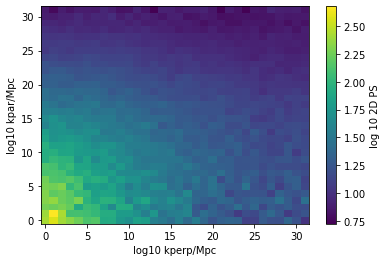

In [47]:
img = plt.imshow(np.log10(PS_2D_final), 
           origin = 'lower',
           aspect = 'auto'
           )
cbar = plt.colorbar(img)
cbar.set_label("log 10 2D PS")
plt.ylabel('log10 kpar/Mpc')
plt.xlabel('log10 kperp/Mpc')
plt.show()

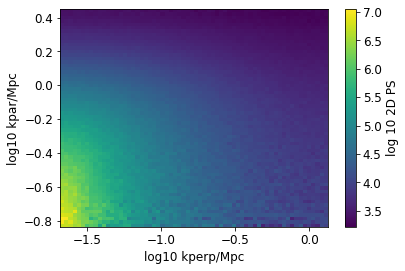

In [424]:
img = plt.imshow(np.log10(PS_2D_final), 
           origin = 'lower', 
           extent = [np.log10(kpar[0]), np.log10(kpar[-1]), np.log10(kperp[0]), np.log10(kperp[-1])],
           aspect = 'auto'
           )
cbar = plt.colorbar(img)
cbar.set_label("log 10 2D PS")
plt.ylabel('log10 kpar/Mpc')
plt.xlabel('log10 kperp/Mpc')
plt.show()

In [205]:
PS_1D, k, var_1D = pb.get_power(lightcones[100],
                                300.,
                                get_variance = True,
                                bin_ave = True,
                                bins = 10**np.linspace(-1.25, 0.28, nbins+1),
                                log_bins = True
                                )

In [306]:
PS_1D2, k2, var_1D = pb.get_power(PS_2D_final,
                                300.,
                                get_variance = True,
                                bin_ave = True,
                                bins = 10**np.linspace(-1.25, 0.5, nbins+1),
                                log_bins = True
                                )

In [220]:
fnames = glob('/home/dprelogovic/code/21cm_IMNN/data/final/lightcones/default_772b8f424530e51b1de8b9e57a47ba49_seed*.npy')

In [221]:
len(fnames)

1024

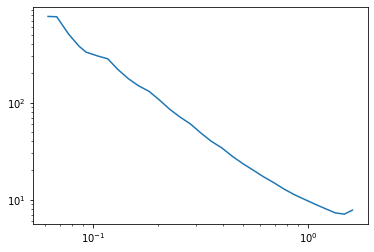

In [198]:
plt.plot(k, PS_1D)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [17]:
k_1D_new, PS_1D_new = PS_2D_to_1D(kperp, kpar, PS_2D_final)
plt.plot(k_1D_new,PS_1D_new, label = 'From 2D PS')
plt.plot(k, PS_1D, label = '1D PS from pb')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

NameError: name 'kperp' is not defined

In [16]:
def PS_2D_to_1D(kperp, kpar, PS_2D, k = None):
    # Calculate radial average of power spectrum
    [rows, cols] = PS_2D.shape
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    R = np.sqrt(X**2 + Y**2)
    R = R.astype(np.int)

    maxR = int(np.max(R))
    avgPS = np.zeros(maxR+1)
    avgk = np.zeros(maxR+1)

    # Calculate k grid to obtain |k|
    X, Y = np.meshgrid(kpar, kperp)
    [rows, cols] = P.shape
    kgrid = np.sqrt(X**2 + Y**2)


    for i in range(maxR+1):
        weights = (4*np.pi*X[R==i])
        avgPS[i] = np.nansum(P[R==i] * weights)/np.nansum(weights)
        avgk[i] = np.nanmean(kgrid[R==i])
    if k is not None:
        f = interp1d(avgk, avgPS, fill_value = 'extrapolate')
        return k, f(k)
    else:
        return avgk, avgPS

In [17]:
lightcone = p21.run_lightcone(
    redshift = 7.0,
    max_redshift = 12.0,
    user_params = {"HII_DIM":200, "BOX_LEN": 200},
    lightcone_quantities=lightcone_quantities,
    global_quantities=lightcone_quantities,
    direc='_cache'
)

KeyboardInterrupt: 

In [177]:
ds = 'Variance' #'Variance_new' 'Test_new'
zs = np.load(path + ds + '_PS_2D_z.npy')
kpar = np.load(path + ds + '_PS_2D_k_par.npy')
kperp = np.load(path + ds + '_PS_2D_k_perp.npy')

In [179]:
10**kpar, 10**kperp

(array([1.0093706, 1.0138681, 1.0205461, 1.030488 , 1.0453463, 1.0676796,
        1.1015344, 1.1534996, 1.2347516, 1.3653162], dtype=float32),
 array([1.0095342, 1.0146096, 1.0224164, 1.0344651, 1.0531561, 1.0823798,
        1.128622 , 1.2031484, 1.3266793, 1.5404401], dtype=float32))

In [24]:
10**kpar

array([1.0093706, 1.0138681, 1.0205461, 1.030488 , 1.0453463, 1.0676796,
       1.1015344, 1.1534996, 1.2347516, 1.3653162], dtype=float32)

In [16]:
lightcone.density.shape

(200, 200, 1209)

In [54]:
nbins = 38
Pk, bins, var, freq = pb.get_power(lightcone.brightness_temp, lightcone.user_params.BOX_LEN, res_ndim = 2, get_variance = True, bin_ave = False, bins = nbins, log_bins = True)

In [55]:
bins

array([0.03141593, 0.03578841, 0.04076945, 0.04644376, 0.05290782,
       0.06027155, 0.06866017, 0.07821632, 0.0891025 , 0.10150382,
       0.11563116, 0.13172475, 0.15005825, 0.17094341, 0.19473538,
       0.22183873, 0.25271433, 0.28788721, 0.32795546, 0.37360043,
       0.42559829, 0.48483322, 0.5523125 , 0.62918357, 0.71675358,
       0.81651162, 0.93015403, 1.05961323, 1.20709061, 1.37509395,
       1.56648006, 1.78450336, 2.03287124, 2.31580705, 2.63812197,
       3.00529681, 3.42357519, 3.90006972, 4.44288294])

In [56]:
freq

array([array([-18.97521963, -18.9438037 , -18.91238777, ...,  18.91238777,
               18.9438037 ,  18.97521963])                                ],
      dtype=object)

In [57]:
Pk.shape

(38, 1209)

In [58]:
var.shape

(38, 1209)

In [59]:
freq = freq[0]

out = Pk.reshape((nbins, 39,31))
freq_new = freq.reshape((39,31))
var_new = var.reshape((nbins, 39,31))

Pk_rebinned = np.nanmean(out, axis = -1)
freq_new = np.nanmean(freq_new, axis = -1)
var_rebinned = np.nanmean(var_new, axis = -1)

/var/tmp/pbs.153888.pbs01/ipykernel_216439/3036803493.py:7: RuntimeWarning: Mean of empty slice
  Pk_rebinned = np.nanmean(out, axis = -1)
/var/tmp/pbs.153888.pbs01/ipykernel_216439/3036803493.py:9: RuntimeWarning: Mean of empty slice
  var_rebinned = np.nanmean(var_new, axis = -1)


In [60]:
Pk_rebinned.shape, var_rebinned.shape, freq_new.shape

((38, 39), (38, 39), (39,))

In [61]:
m = freq_new > 1e-10
k_final = freq_new[m]
Pk_rebinned_final = Pk_rebinned[:,m]
var_rebinned_final = var_rebinned[:,m]

m2 = ~np.isnan(bins)
Pk_rebinned_final = Pk_rebinned_final[m2,:]
var_rebinned_final = var_rebinned_final[m2,:]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 38 but corresponding boolean dimension is 39

In [40]:
k_final, len(k_final) # this is kperp

(array([6.4516129 , 3.22580645, 2.15053763, 1.61290323, 1.29032258,
        1.07526882, 0.92165899, 0.80645161, 0.71684588, 0.64516129,
        0.58651026, 0.53763441, 0.49627792, 0.46082949, 0.43010753,
        0.40322581, 0.37950664, 0.35842294, 0.33955857]),
 19)

In [41]:
bins[m2], len(bins[m2]) #this is kpar

(array([0.03141593, 0.04442883, 0.06283185, 0.07024815, 0.08885766,
        0.09764651, 0.11327173, 0.12824202, 0.13809303, 0.16142566,
        0.18579527, 0.20587201, 0.23312627, 0.26805385, 0.30694005,
        0.34921536, 0.39888958, 0.45598293, 0.51968947, 0.59268657,
        0.6741864 , 0.76616864, 0.87284971, 0.99547888, 1.13511246,
        1.29250093, 1.47201018, 1.67743355, 1.91115543, 2.17716653,
        2.47938975, 2.82487952, 3.18862412, 3.63124003, 4.07840251]),
 35)

In [42]:
np.log10(freq_new[m])

array([-0.01148843,  0.28954156,  0.46563282,  0.59057156,  0.68748157,
        0.76666282,  0.83360961,  0.89160155,  0.94275408,  0.98851157,
        1.02990425,  1.06769281,  1.10245492,  1.1346396 ,  1.16460283,
        1.19263155,  1.21896049,  1.24378407,  1.26726517])

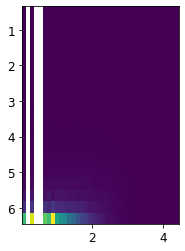

In [62]:
plt.imshow(Pk_rebinned_final.T, origin = 'lower', extent = [bins[m2][1], bins[m2][-1], k_final[0], k_final[-1]])
plt.show()

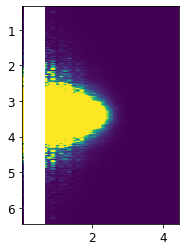

In [63]:
plt.imshow(var.T, origin = 'lower', vmin = 1e1, vmax = 1e4,
           extent = [bins[m2][1], bins[m2][-1], k_final[0], k_final[-1]])
plt.show()

In [37]:
what[0]

array([-37.95043926, -37.8876074 , -37.82477555, ...,  37.82477555,
        37.8876074 ,  37.95043926])

In [176]:
path = '/projects/cosmo_database/dbreitman/21cm_emulator/data/21cm_emulator/'

In [42]:
# Calculate the mean PS for each group and save it.
for ds in ['Variance', 'Variance_new', 'Test_new']:
    inps = np.load(path + ds + '_PS_2D_inputs.npy')
    zs = np.load(path + ds + '_PS_2D_z.npy')
    first_param_unique, idx, cts = np.unique(inps[:,0], return_counts = True, return_index = True)
    idx_sort = np.argsort(idx)
    idx = idx[idx_sort]
    cts = cts[idx_sort]
    print(ds, cts)
    # Variance: [51 50 50 50 50 50 20 45 50]
    # Variance_new: [50 50]
    # Test_new: [45 56 80 65 30 10]
    first_param_unique = first_param_unique[idx_sort]
    num_param_combs = len(first_param_unique)

    ps = np.load(path + ds + '_PS_2D_delta.npy')
    kpar = np.load(path + ds + '_PS_2D_k_par.npy')
    kperp = np.load(path + ds + '_PS_2D_k_perp.npy')
    mean_PS = np.zeros((num_param_combs, len(zs), len(kpar), len(kperp)))
    final_database = np.zeros((inps.shape[0], len(zs), len(kpar), len(kperp), 2))
    CV = np.zeros((len(cts), len(zs), len(kpar), len(kperp)))
    CV_1D = np.zeros((len(cts), len(zs), len(kpar)-1))
    for i in range(num_param_combs):
        print(inps[idx[i]+cts[i]-1,0], first_param_unique[i])
        tmp_ps = ps[idx[i]:idx[i]+cts[i],...]
        mean_PS[i,...] = np.nanmean(tmp_ps, axis = 0)
        CV[i,...] = np.nanstd(tmp_ps, axis = 0) / np.nanmean(tmp_ps, axis = 0)
        CV_1D[i,...] = np.nanstd(np.nansum(tmp_ps * kperp, axis = -1)[...,:-1] * np.diff(kpar), axis = 0)
        final_database[idx[i]:idx[i] + cts[i], ..., 0] = tmp_ps 
        final_database[idx[i]:idx[i] + cts[i], ..., 1] = mean_PS[i,...]
    print(final_database.shape)    
    # Make a database: col1: seed 2D PS col2: corresponding mean PS
    #np.save(ds + '_PSCV_meanPS.npy', final_database)
    #np.save(ds + '_CV.npy', CV)
    #np.save(ds + '_1D_CV.npy', CV_1D)

Variance [51 50 50 50 50 50 20 45 50]
-1.2776519 -1.2776519
-1.2407452 -1.2407452
-1.0834025 -1.0834025
-1.2947675 -1.2947675
-1.2542026 -1.2542026
-1.4157115 -1.4157115
-1.2222433 -1.2222433
-1.0436002 -1.0436002
-1.2476735 -1.2476735


/var/tmp/pbs.122103.pbs01/ipykernel_6291/1153346040.py:26: RuntimeWarning: Mean of empty slice
  mean_PS[i,...] = np.nanmean(tmp_ps, axis = 0)
/var/tmp/pbs.122103.pbs01/ipykernel_6291/1153346040.py:27: RuntimeWarning: Mean of empty slice
  CV[i,...] = np.nanstd(tmp_ps, axis = 0) / np.nanmean(tmp_ps, axis = 0)
/var/tmp/pbs.122103.pbs01/ipykernel_6291/1153346040.py:27: RuntimeWarning: invalid value encountered in true_divide
  CV[i,...] = np.nanstd(tmp_ps, axis = 0) / np.nanmean(tmp_ps, axis = 0)


(416, 118, 10, 10, 2)
Variance_new [50 50]
-1.2407452 -1.2407452
-1.2947675 -1.2947675
(100, 118, 10, 10, 2)
Test_new [45 56 80 65 30 10]
-1.142018742355184 -1.142018742355184
-1.3510484280180999 -1.3510484280180999
-1.3753991983557554 -1.3753991983557554
-1.2716345864772807 -1.2716345864772807
-1.4183581079107122 -1.4183581079107122
-1.1937274657598624 -1.1937274657598624
(286, 118, 10, 10, 2)


### CV is variance on the seeds as a fnc of k bins and z (use only training to make it)

In [43]:
# Combine the three inputs
for ds in ['Variance', 'Variance_new', 'Test_new']:
    inps = np.load(path + ds + '_PS_2D_inputs.npy')
    cv = np.load(ds + '_CV.npy')
    cv_1d = np.load(ds + '_1D_CV.npy')
    if ds == 'Variance':
        inpsfinal = inps.copy()
        cvfinal = cv.copy()
        cv1final = cv_1d.copy()
    else:
        inpsfinal = np.append(inpsfinal, inps, axis = 0)
        if ds != 'Variance_new':
            cvfinal = np.append(cvfinal, cv, axis = 0)
            cv1final = np.append(cv1final, cv_1d, axis = 0)
print('input: ',inpsfinal.shape)
print('cv: ', cvfinal.shape)
first_param_unique, idx, cts = np.unique(inpsfinal[:,0], return_counts = True, return_index = True)
idx_sort = np.argsort(idx)
idx = idx[idx_sort]
cts = cts[idx_sort]
first_param_unique = first_param_unique[idx_sort]
num_param_combs = len(first_param_unique)
num_instances_inp = np.zeros(inpsfinal.shape[0])
for i in range(num_param_combs):
    print(inpsfinal[idx[i]+cts[i]-1,0], first_param_unique[i])
    num_instances_inp[idx[i]:idx[i] + cts[i]] = cts[i]
finalinps = np.append(inpsfinal, num_instances_inp[...,np.newaxis], axis = 1)
#np.save('final_PSCV_params.npy', finalinps)
#np.save('train_CV_final.npy', np.nanmean(cvfinal, axis = 0))
#np.save('train_CV_1D_final.npy', np.nanmean(cv1final, axis = 0))

input:  (802, 5)
cv:  (15, 118, 10, 10)
-1.2776519060134888 -1.2776519060134888
-1.0834025144577026 -1.240745186805725
-1.0834025144577026 -1.0834025144577026
-1.2542026042938232 -1.2947674989700317
-1.2542026042938232 -1.2542026042938232
-1.415711522102356 -1.415711522102356
-1.222243309020996 -1.222243309020996
-1.0436002016067505 -1.0436002016067505
-1.247673511505127 -1.247673511505127
-1.142018742355184 -1.142018742355184
-1.3510484280180999 -1.3510484280180999
-1.3753991983557554 -1.3753991983557554
-1.2716345864772807 -1.2716345864772807
-1.4183581079107122 -1.4183581079107122
-1.1937274657598624 -1.1937274657598624


/var/tmp/pbs.122103.pbs01/ipykernel_6291/999211737.py:29: RuntimeWarning: Mean of empty slice
  np.save('train_CV_final.npy', np.nanmean(cvfinal, axis = 0))


In [4]:
print(ds1.shape)
print(ds2.shape) #This is two parameter sets w 50 seeds each. Make this test set.
print(ds3.shape)

(286, 118, 10, 10, 2)
(100, 118, 10, 10, 2)
(416, 118, 10, 10, 2)


### One of the three datasets is for testing only

In [5]:
# Combine the three datasets
ds1 = np.load('Test_new_PSCV_meanPS.npy')
ds2 = np.load('Variance_new_PSCV_meanPS.npy') #Make this test set.
ds3 = np.load('Variance_PSCV_meanPS.npy')
data = np.append(ds1, ds3, axis = 0)
floor = 1e-10
data[data < floor] = floor
data[np.isnan(data)] = floor

#np.save('train_final_PSCV_meanPS_wfloor.npy', data)
# shape of final dataset = (702, 118, 10, 10, 2)

In [ ]:
CV = np.zeros((len(zs), len(kpar), len(kperp)))
inpsfinal = np.load('final_PSCV_params.npy')
print(inpsfinal.shape)
first_param_unique, idx, cts = np.unique(inpsfinal[:,0], return_counts = True, return_index = True)
idx_sort = np.argsort(idx)
idx = idx[idx_sort]
cts = cts[idx_sort]
for i in range(num_param_combs):
    j = 0
    print(inps[idx[i]+j,0], first_param_unique[i])
    for j in range(cts[i]):
        if j == 0:
            tmp_ps = np.zeros((1, len(zs), len(kpar), len(kperp)))
            tmp_ps[0,...] = ps[idx[i]+j,...]
        else:
            tmp_ps = np.append(tmp_ps, ps[idx[i] + j,...][np.newaxis], axis = 0)
        j += 1
    print(tmp_ps.shape)
    CV[i,...] = np.nanstd(tmp_ps, axis = 0)
    final_database[idx[i]:idx[i] + cts[i], ..., 0] = tmp_ps 
    final_database[idx[i]:idx[i] + cts[i], ..., 1] = mean_PS[i,...]
print(final_database.shape)    

In [8]:
floor = 1e-10
ds2[ds2 < floor] = floor
ds2[np.isnan(ds2)] = floor

#np.save('test_final_PSCV_meanPS_wfloor.npy', ds2)

In [27]:
data = np.load('train_final_PSCV_meanPS_wfloor.npy')

In [4]:
def normalize(data: np.ndarray, N: int = None):
    # Normalize data by column
    if N is None:
        N = data.shape[0]
    d = data
    # Normalization uses training set only (hence :N)
    # Normalize each data set together
    mean, std = np.nanmean(d[:N,...]), np.nanstd(d[:N,...])

    normed = (d - mean)/std          
    
    print('Subtracted mean: ', mean)
    print('Divided by std: ', std)
    return normed, mean, std

def plot_hist(h, lmin = None, lmax = None):
    y = h.history['loss']
    plt.plot(np.arange(len(y)),y, label = 'loss', color = 'k')
    y = h.history['val_loss']
    plt.plot(np.arange(len(y)),y, label = 'val_loss', color = 'orange')
    #plt.yscale('log')
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch')
    try: 
        y2 = h.history['root_mean_squared_error']
        y2_val = h.history['val_root_mean_squared_error']
    except:
        print('No RMSE available.')
    else:
        plt.plot(np.arange(len(y)),y2, label = 'RMSE', color = 'b')
        plt.plot(np.arange(len(y)),y2_val, label = 'val_RMSE', color = 'cyan')
    if lmin is not None and lmax is not None:
        plt.ylim(lmin, lmax)
    plt.legend()
    #plt.savefig(path + 'loss' + name + '.png', dpi = 300)
    plt.show()
        
    y = h.history['lr']
    plt.plot(np.arange(len(y)),y)
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    #plt.savefig(path + 'lr' + name + '.png', dpi = 300)
    plt.show()

In [31]:
# Ignore the redshift axis (i.e. 2D instead of 3D images)
print(data.shape)
data = data.reshape((data.shape[0] * data.shape[1], data.shape[2], data.shape[3], data.shape[4]))
print(data.shape)

(802, 118, 10, 10, 2)
(94636, 10, 10, 2)


In [32]:
#idx = np.arange(data.shape[0])
#np.random.shuffle(idx)
#np.save('idx_woutz.npy', idx)

In [29]:
idx = np.load('idx_woutz.npy')

In [33]:
f_train = 0.6
f_valid = 1 - f_train - 0.1

features = data[...,0]
outputs = np.log10(data[...,1])

N_train = int(np.round(len(features) * f_train))
N_valid = int(np.round(len(features) * f_valid))

print('Training set size: ', N_train)
print('Validation set size: ', N_valid)

dataset = data[idx]

X_train = features[:N_train]
X_valid = features[N_train:N_train+N_valid]

outputs = np.nan_to_num(outputs)
normed_outputs, normed_mean, normed_std = normalize(outputs, N_train)

Y_train = normed_outputs[:N_train]
Y_valid = normed_outputs[N_train:N_train+N_valid]

Training set size:  56782
Validation set size:  28391
Subtracted mean:  -6.556383247964717
Divided by std:  2.2586509601060616
